In [1]:
import bayes3d as b
import jax
import jax.numpy as jnp
import numpy as np
import os
import trimesh
import copy
import open3d as o3d
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import io

intrinsics = j.Intrinsics(
    height=100,
    width=100,
    fx=100.0, fy=100.0,
    cx=50.0, cy=50.0,
    near=1.0, far=500.0
)


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
j.meshcat.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


In [77]:
table_params = (1000.0,
    1000.0,
    0.01,
    0.01,
    0.01)
table_mesh = j.mesh.make_table_mesh(
    *table_params
)
table_dims = j.utils.aabb(table_mesh.vertices)[0]
table_pose = j.t3d.inverse_pose(
    j.t3d.transform_from_pos_target_up(
        jnp.array([0.0, 300.0, 150.0]),
        jnp.array([0.0, 0.0, 0.0]),
        jnp.array([0.0, 0.0, 1.0]),
    )
)
contact_plane = table_pose @ j.scene_graph.contact_planes(table_dims)[2]

In [135]:
occluder = j.mesh.make_cuboid_mesh(jnp.array([10.0, 70.0, 60.0]))                       
obj_a = j.mesh.make_cuboid_mesh(jnp.array([50.0, 100.0, 50.0]))                       
obj_b = j.mesh.make_cuboid_mesh(jnp.array([50.0, 60.0, 50.0]))
obj_c = j.mesh.make_cuboid_mesh(jnp.array([50.0, 20.0, 50.0]))
renderer = j.Renderer(intrinsics, num_layers=1024)
renderer.add_mesh(occluder)
renderer.add_mesh(obj_a)
renderer.add_mesh(obj_b)
renderer.add_mesh(obj_c)

Increasing frame buffer size to (width, height, depth) = (128, 128, 1024)


[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


In [136]:
def sample_image(object_poses, object_ids, r_array):
    reconstruction = renderer.render_multiobject(
        object_poses, object_ids
    )
    rendered_seg = reconstruction[:,:,3]
    r = r_array[jnp.abs(rendered_seg[..., None] - jnp.arange(len(r_array))).argmin(-1)]
    key = jax.random.PRNGKey(10)
    noisy_point_cloud_image = jax.random.multivariate_normal(
        key, reconstruction[:,:,:3], (jnp.eye(3)[None, None, :, :] * r[:,:,None,None]), shape=r.shape
    )
    img = j.render_point_cloud(noisy_point_cloud_image.reshape(-1,3), intrinsics)
    return img

def inference():
    all_hypotheses = []
    for obj_id in range(1,len(renderer.meshes)):
#         print("Object ID ", obj_id)
        contact_param = jnp.zeros(3)
        p = None
        for c2f_iter in range(len(contact_param_gridding_schedule)):
            contact_param_grid = contact_param_gridding_schedule[c2f_iter] + contact_param

            potential_new_object_poses = pose_from_contact_and_face_params_parallel_jit(
                contact_param_grid,
                3,
                renderer.model_box_dims[obj_id],
                contact_plane
            )
            POTENTIAL_R = jnp.hstack([jnp.tile(R[None,:], (R_SWEEP.shape[0], 1)),R_SWEEP])

            potential_poses = jnp.concatenate(
                [
                    jnp.tile(object_poses, (1,potential_new_object_poses.shape[0],1,1)),
                    potential_new_object_poses[None,...]
                ]
            )
            reconstruction = renderer.render_multiobject_parallel(
                potential_poses, object_ids + [obj_id]
            )
            p = j.threedp3_likelihood_multi_r_full_hierarchical_bayes_jit(
                observed_point_cloud_image,
                reconstruction[:,:,:,:3],
                reconstruction[:,:,:, -1],
                POTENTIAL_R, OUTLIER_PROBS, OUTLIER_VOLUME, 11
            )
            
            ii,jj,kk = jnp.unravel_index(p.argmax(), p.shape)
            contact_param = contact_param_grid[ii]
    #         print(contact_param)
    #         print(POTENTIAL_R[jj])

        best_r, best_outlier_prob = (POTENTIAL_R[jj], OUTLIER_PROBS[kk])

        all_hypotheses.append(
            (p[ii,jj,kk], reconstruction[ii], best_r, best_outlier_prob, potential_poses[:,ii], obj_id)
        )

    return all_hypotheses

In [137]:
sched = [(100.0, jnp.pi), (50.0, jnp.pi), (10.0, jnp.pi),
         (5.0, jnp.pi/2),(5.0, jnp.pi/2),(5.0, jnp.pi/2),
         (2.0, jnp.pi/2),(2.0, jnp.pi/2),(2.0, jnp.pi/2),
         (1.0, jnp.pi/4),(1.0, jnp.pi/4),(1.0, jnp.pi/4),
]

contact_param_gridding_schedule = [
    j.make_translation_grid_enumeration_3d(
        -x, 0.0, -y,
        x, 0.0, y,
        13,1,3
    )
    for (x,y) in sched
]

pose_from_contact_and_face_params_parallel_jit = jax.jit(jax.vmap(j.scene_graph.pose_from_contact_and_face_params, in_axes=(0,None, None, None)))


R_SWEEP = jnp.array([100.0, 50.0, 10.0, 5.0]).reshape(-1,1)
print(R_SWEEP)
OUTLIER_PROBS = jnp.linspace(0.01, 0.2, 4)
OUTLIER_VOLUME = 100.0**3 * 0.01
SCALING_FACTOR = 3

[[100.]
 [ 50.]
 [ 10.]
 [  5.]]


[Array([10., 10.,  5.], dtype=float32), Array([10., 10.,  5.], dtype=float32), Array([10., 10.,  5.], dtype=float32)]
[Array(0.2, dtype=float32), Array(0.2, dtype=float32), Array(0.2, dtype=float32)]
SCORES   [-107936.97 -107945.25 -107960.72]
NORMALIZED SCORES   [1.0000000e+00 2.5322047e-04 4.8473687e-11]
[0 1 2]
Best
[10. 10.  5.] 0.2 1
[Array(0, dtype=int32), 1]


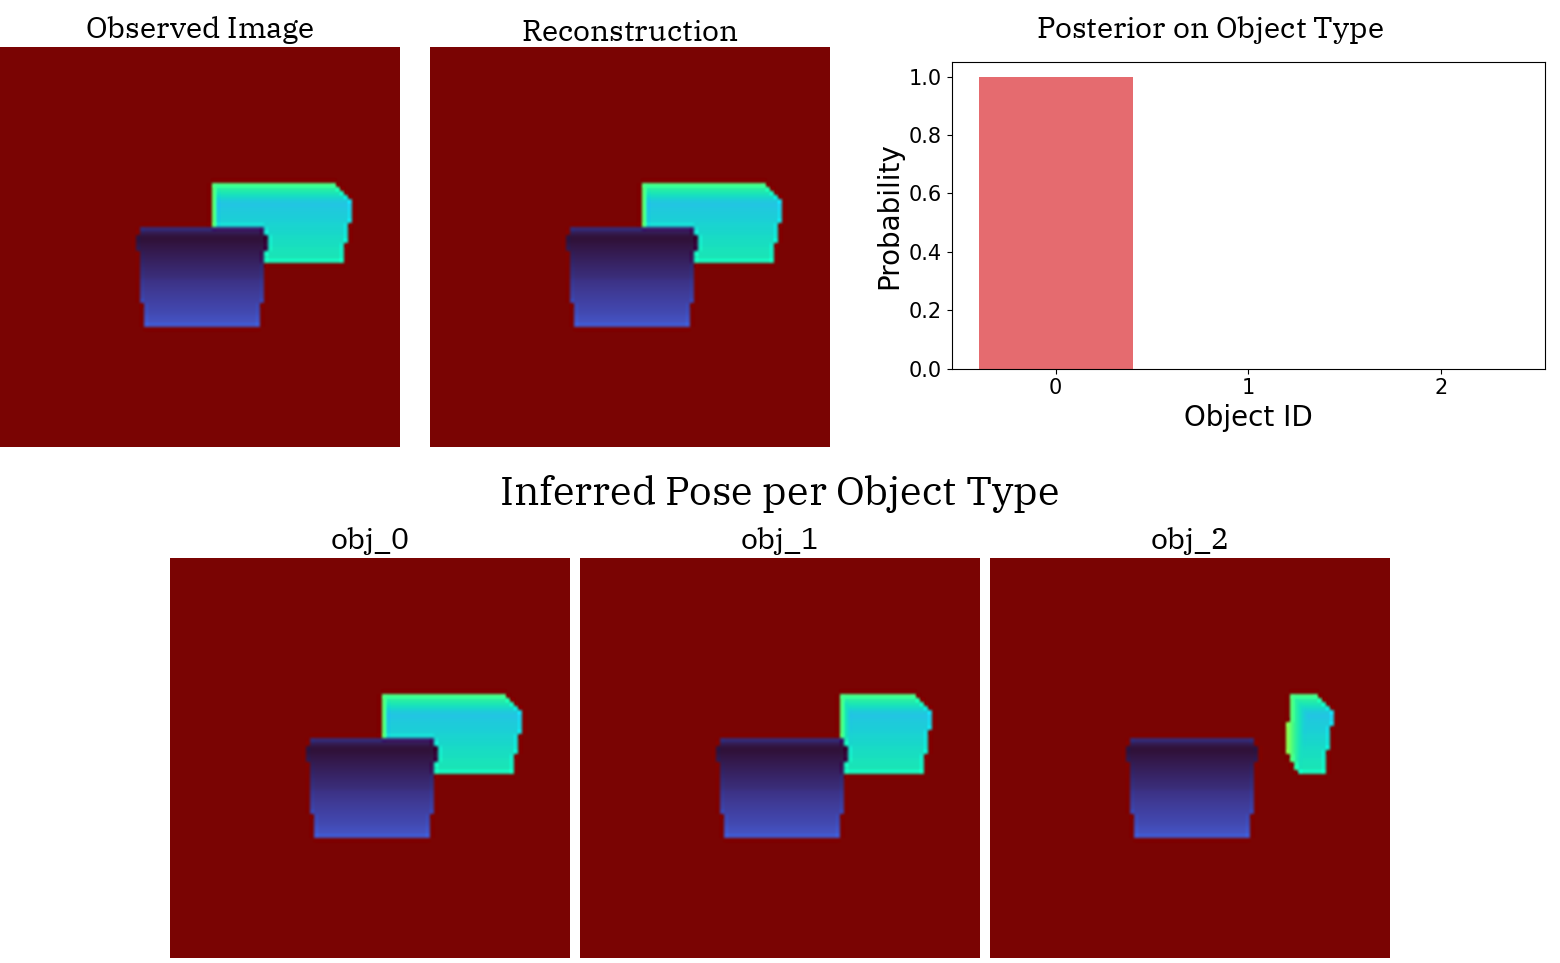

<Figure size 640x480 with 0 Axes>

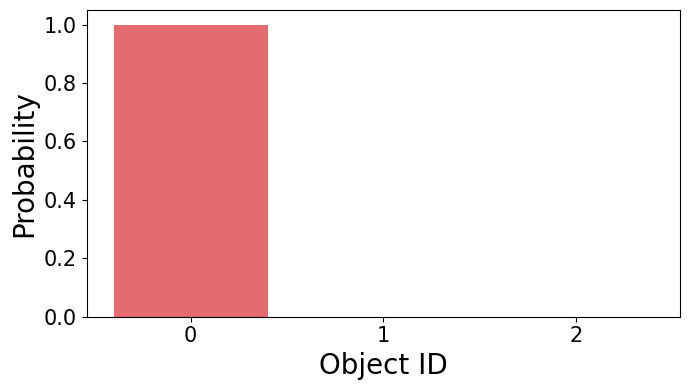

In [138]:
object_indices = jnp.array([0,1])

poses = j.scene_graph.pose_from_contact_and_face_params_multiobject_jit(
    jnp.array(
        [
            [0.0, 100.0, 0.0],
            [-60.0, 0.0, 0.0],
        ]
    ),
    jnp.array([3,3]),
    renderer.model_box_dims[object_indices],
    contact_plane
)
SCALING_FACTOR = 4
observed_point_cloud_image = renderer.render_multiobject(poses, object_indices)
j.meshcat.show_cloud("obs", observed_point_cloud_image[:,:,:3].reshape(-1,3) / 1000.0)
j.scale_image(j.get_depth_image(observed_point_cloud_image[:,:,2]),SCALING_FACTOR)

R = jnp.array([10.0, 10.0])
object_poses, object_ids = poses[:1,:,:][None,...], [object_indices[0]]
reconstruction = renderer.render_multiobject(
    object_poses, object_ids
)

all_hypotheses = inference()
print([i[2] for i in all_hypotheses])
print([i[3] for i in all_hypotheses])

scores = jnp.array([i[0] for i in all_hypotheses])
normalized_scores = j.utils.normalize_log_scores(scores)
print("SCORES  ", scores)
print("NORMALIZED SCORES  ", normalized_scores)
print(jnp.argsort(-scores))
best_hypothesis = all_hypotheses[jnp.argmax(scores)]
score, reconstruction, best_r, best_outlier_prob, best_poses, obj_id = best_hypothesis
print("Best")
print(best_r, best_outlier_prob, obj_id)

R = best_r
object_poses = best_poses[:,None,...]
object_ids = object_ids + [obj_id]
print(object_ids)



# height_factor = outlier_prob_viz.height / observed_image_viz.height

plt.clf()
plt.figure(figsize=(7,4))
color = np.array([229, 107, 111])/255.0
plt.bar(
    np.arange(len(normalized_scores)),
    normalized_scores,
    color=color
)
plt.xticks(np.arange(len(normalized_scores)), ["{:d}".format(i) for i in range(len(normalized_scores))],fontsize=15)
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0],fontsize=15)
plt.xlabel("Object ID",fontsize=20)
plt.ylabel("Probability",fontsize=20)
plt.ylim(0.0, 1.05)
plt.tight_layout()
img_buf = io.BytesIO()
plt.savefig(img_buf, format='png')
posterior_bar_chart = Image.open(img_buf)

depth_viz = j.scale_image(j.get_depth_image(observed_point_cloud_image[:,:,2]), SCALING_FACTOR)

height_factor = depth_viz.height / posterior_bar_chart.height


viz1 = j.multi_panel(
    [
        depth_viz,
        j.scale_image(j.get_depth_image(reconstruction[:,:,2]), SCALING_FACTOR),
        j.scale_image(posterior_bar_chart, height_factor)
    ],
    labels=[
        "Observed Image",
        "Reconstruction",
        "Posterior on Object Type",
    ],
    middle_width=30
)

viz2 = j.multi_panel(
    [j.scale_image(j.get_depth_image(r[1][:,:,2]), SCALING_FACTOR) for r in all_hypotheses],
    labels=["obj_{:d}".format(idx, i.item()) for (idx,i) in enumerate(normalized_scores)],
    title="Inferred Pose per Object Type"
)

viz3 = j.multi_panel(
    [j.scale_image(j.get_depth_image(sample_image(r[4][None,...], [object_indices[0],r[5]], r[2])[:,:,2]), SCALING_FACTOR) for r in all_hypotheses],
    labels=["obj_{:d}, Noise: {:0.2f}".format(idx, i[2][-1].item()) for (idx,i) in enumerate(all_hypotheses)],
    title="Posterior Samples per Object Type"
)

final_viz = j.vstack_images([viz1, viz2])
final_viz

In [139]:
## IDX = 0
j.meshcat.clear()
j.meshcat.show_cloud("1", observed_point_cloud_image[:,:,:3].reshape(-1,3) / 500.0)
j.meshcat.show_cloud("2", all_hypotheses[IDX][1][:,:,:3].reshape(-1,3) / 500.0, color=j.RED)

NameError: name 'IDX' is not defined

In [140]:
j.scene_graph.pose_from_contact_and_face_params(
    jnp.array([0.0, 0.0, 0.0]),
    3,
    renderer.model_box_dims[1],
    contact_plane
)

Array([[ 5.9604645e-08,  1.0000000e+00,  2.5611371e-08,  6.3946936e-07],
       [ 4.4726562e-01,  4.9568825e-08, -8.9453125e-01, -2.2367760e+01],
       [-8.9453125e-01, -4.1863359e-08, -4.4726562e-01,  3.2431836e+02],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.0000000e+00]],      dtype=float32)

x : -120.0
SCORES   [-107785.44 -107793.06 -107809.25]
NORMALIZED SCORES   [1.0000000e+00 4.8809528e-04 4.5536814e-11]
[0 1 2]
Best
[10.  1.  5.] 0.2 1
[Array(0, dtype=int32), 1]
x : -115.10204
SCORES   [-107784.2  -107793.75 -107809.93]
NORMALIZED SCORES   [1.000000e+00 7.142412e-05 6.715771e-12]
[0 1 2]
Best
[10.  1.  5.] 0.2 1
[Array(0, dtype=int32), 1]
x : -110.20409
SCORES   [-107782.984 -107794.516 -107811.43 ]
NORMALIZED SCORES   [1.000000e+00 9.818424e-06 4.429531e-13]
[0 1 2]
Best
[10.  1.  5.] 0.2 1
[Array(0, dtype=int32), 1]
x : -105.30612
SCORES   [-107781.74 -107795.56 -107811.89]
NORMALIZED SCORES   [1.000000e+00 9.952096e-07 8.066775e-14]
[0 1 2]
Best
[10.  1.  5.] 0.2 1
[Array(0, dtype=int32), 1]
x : -100.40816
SCORES   [-107780.92 -107796.19 -107812.17]
NORMALIZED SCORES   [1.0000000e+00 2.3454345e-07 2.6810040e-14]
[0 1 2]
Best
[10.  1.  5.] 0.2 1
[Array(0, dtype=int32), 1]
x : -95.51021
SCORES   [-107781.1   -107796.125 -107812.03 ]
NORMALIZED SCORES   [1.0000000e+00

/tmp/ipykernel_19313/1051299399.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(7,4))


SCORES   [-107791.36 -107799.25 -107807.89]
NORMALIZED SCORES   [1.0000000e+00 3.7423562e-04 6.6156019e-08]
[0 1 2]
Best
[10.  1.  5.] 0.2 1
[Array(0, dtype=int32), 1]
x : -17.142853
SCORES   [-107792.03  -107799.94  -107808.336]
NORMALIZED SCORES   [1.0000000e+00 3.6843363e-04 8.2978232e-08]
[0 1 2]
Best
[10.  1.  5.] 0.2 1
[Array(0, dtype=int32), 1]
x : -12.244892
SCORES   [-107792.766 -107800.56  -107808.98 ]
NORMALIZED SCORES   [1.0000000e+00 4.1101739e-04 9.1133764e-08]
[0 1 2]
Best
[10.  1.  5.] 0.2 1
[Array(0, dtype=int32), 1]
x : -7.346939
SCORES   [-107793.375 -107801.234 -107809.67 ]
NORMALIZED SCORES   [1.0000000e+00 3.8611513e-04 8.3629040e-08]
[0 1 2]
Best
[10.  1.  5.] 0.2 1
[Array(0, dtype=int32), 1]
x : -2.4489746
SCORES   [-107794.055 -107802.02  -107810.29 ]
NORMALIZED SCORES   [1.0000000e+00 3.4611134e-04 8.9022649e-08]
[0 1 2]
Best
[10.  1.  5.] 0.2 1
[Array(0, dtype=int32), 1]
x : 2.4489784
SCORES   [-107794.05 -107802.02 -107810.29]
NORMALIZED SCORES   [1.000000e+

<Figure size 640x480 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

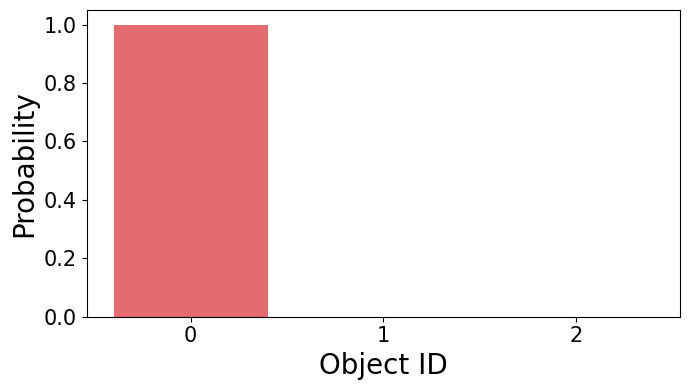

In [141]:
viz_images = []
for block_x in jnp.linspace(-120.0, 120.0, 50):
    print("x :", block_x)
    object_indices = jnp.array([0,1])

    poses = j.scene_graph.pose_from_contact_and_face_params_multiobject_jit(
        jnp.array(
            [
                [0.0, 100.0, 0.0],
                [block_x, 0.0, 0.0],
            ]
        ),
        jnp.array([3,3]),
        renderer.model_box_dims[object_indices],
        contact_plane
    )
    SCALING_FACTOR = 4
    observed_point_cloud_image = renderer.render_multiobject(poses, object_indices)
    j.meshcat.show_cloud("obs", observed_point_cloud_image[:,:,:3].reshape(-1,3) / 1000.0)
    j.scale_image(j.get_depth_image(observed_point_cloud_image[:,:,2]),SCALING_FACTOR)


    R = jnp.array([10.0, 1.0])
    object_poses, object_ids = poses[:1,:,:][None,...], [object_indices[0]]
    reconstruction = renderer.render_multiobject(
        object_poses, object_ids
    )

    all_hypotheses = inference()


    scores = jnp.array([i[0] for i in all_hypotheses])
    normalized_scores = j.utils.normalize_log_scores(scores)
    print("SCORES  ", scores)
    print("NORMALIZED SCORES  ", normalized_scores)
    print(jnp.argsort(-scores))
    best_hypothesis = all_hypotheses[jnp.argmax(scores)]
    score, reconstruction, best_r, best_outlier_prob, best_poses, obj_id = best_hypothesis
    print("Best")
    print(best_r, best_outlier_prob, obj_id)

    R = best_r
    object_poses = best_poses[:,None,...]
    object_ids = object_ids + [obj_id]
    print(object_ids)

    # outliers = (
    #     (1.0 - best_outlier_prob) * (j.gaussian_mixture_image_multi_r_jit(observed_point_cloud_image, reconstruction[:,:,:3], reconstruction[:,:, -1], best_r))
    #         <
    #     (best_outlier_prob / OUTLIER_VOLUME)
    # )

    # height_factor = outlier_prob_viz.height / observed_image_viz.height
    plt.clf()
    plt.figure(figsize=(7,4))
    color = np.array([229, 107, 111])/255.0
    plt.bar(
        np.arange(len(normalized_scores)),
        normalized_scores,
        color=color
    )
    plt.xticks(np.arange(len(normalized_scores)), ["{:d}".format(i) for i in range(len(normalized_scores))],fontsize=15)
    plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0],fontsize=15)
    plt.xlabel("Object ID",fontsize=20)
    plt.ylabel("Probability",fontsize=20)
    plt.ylim(0.0, 1.05)
    plt.tight_layout()
    img_buf = io.BytesIO()
    plt.savefig(img_buf, format='png')
    posterior_bar_chart = Image.open(img_buf)

    depth_viz = j.scale_image(j.get_depth_image(observed_point_cloud_image[:,:,2]), SCALING_FACTOR)

    height_factor = depth_viz.height / posterior_bar_chart.height



    # outlier_viz = j.scale_image(j.get_depth_image(1.0 - outliers), SCALING_FACTOR)
    viz1 = j.multi_panel(
        [
            depth_viz,
            j.scale_image(j.get_depth_image(reconstruction[:,:,2]), SCALING_FACTOR),
            j.scale_image(posterior_bar_chart, height_factor)
        ],
        labels=[
            "Observed Image",
            "Reconstruction",
            "Posterior on Object Type",
        ],
        middle_width=30
    )

    viz2 = j.multi_panel(
        [j.scale_image(j.get_depth_image(r[1][:,:,2]), SCALING_FACTOR) for r in all_hypotheses],
        labels=["obj_{:d}".format(idx, i.item()) for (idx,i) in enumerate(normalized_scores)],
        title="Inferred Pose per Object Type"
    )

    final_viz = j.vstack_images([viz1, viz2])
    viz_images.append(final_viz)


In [142]:
j.make_gif(viz_images, "out.gif")

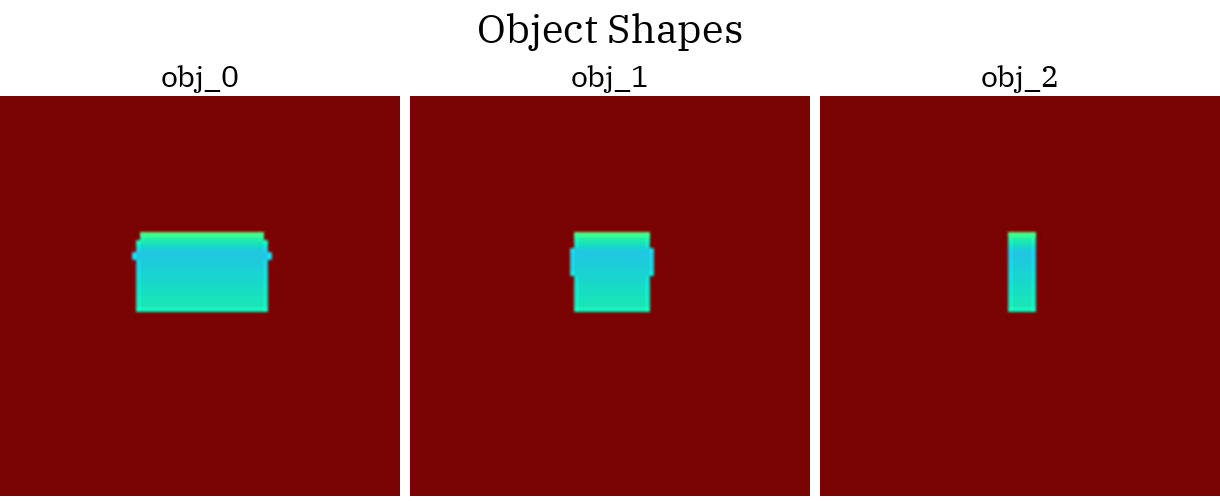

In [121]:
viz_top = j.multi_panel(
    [j.scale_image(j.get_depth_image(
        renderer.render_single_object(
            j.scene_graph.pose_from_contact_and_face_params(
                jnp.array([0.0, 0.0, 0.0]),
                3,
                renderer.model_box_dims[1],
                contact_plane
            )
, i)[:,:,2],min=214.87054
    ), SCALING_FACTOR) for i in range(1,4)],
    labels=["obj_{:d}".format(idx, i.item()) for (idx,i) in enumerate(normalized_scores)],
    title="Object Shapes"
)
viz_top

[1.e-07 1.e-06 1.e+01]


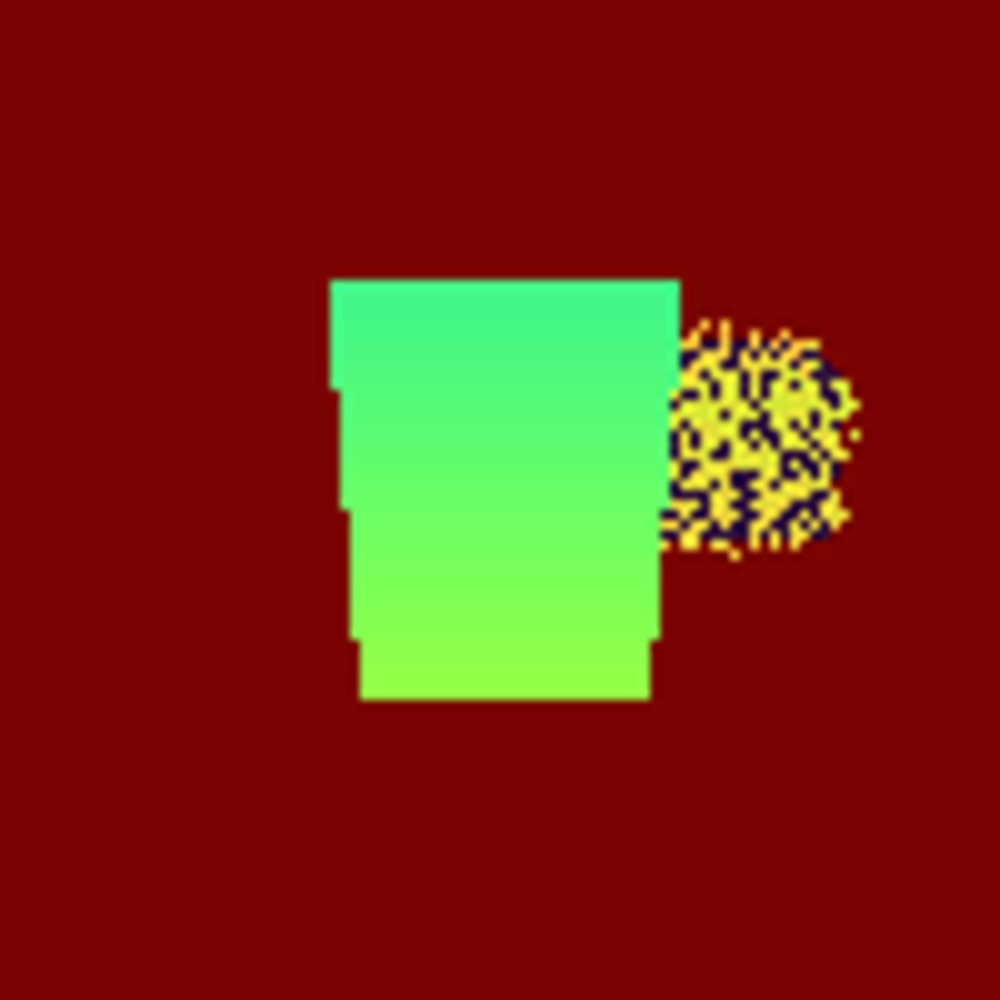

In [22]:
R = jnp.array([0.0000001, 0.000001, 10.0])
reconstruction = renderer.render_multiobject(
    object_poses, object_ids
)

# reconstruction = observed_point_cloud_image
rendered_seg = reconstruction[:,:,3]
j.get_depth_image(reconstruction[:,:,2])
r_array = R
print(r_array, )
r = r_array[jnp.abs(rendered_seg[..., None] - jnp.arange(len(r_array))).argmin(-1)]
key = jax.random.PRNGKey(10)
noisy_point_cloud_image = jax.random.multivariate_normal(
    key, reconstruction[:,:,:3], (jnp.eye(3)[None, None, :, :] * r[:,:,None,None]), shape=r.shape
)
img = j.render_point_cloud(noisy_point_cloud_image.reshape(-1,3), intrinsics)
j.scale_image(j.get_depth_image(img[:,:,2]),10)